# Sentiment Analysis with Scikit-Learn
Sentiment analysis refers to analyzing an opinion or feelings about something using data like text or images, regarding almost anything. Sentiment analysis helps companies in their decision-making process. For instance, if public sentiment towards a product is not so good, a company may try to modify the product or stop the production altogether in order to avoid any losses.

There are many sources of public sentiment e.g. public interviews, opinion polls, surveys, etc. However, with more and more people joining social media platforms, websites like Facebook and Twitter can be parsed for public sentiment.

In this article, we will see how we can perform sentiment analysis of text data.

## Problem Definition
Given tweets about six US airlines, the task is to predict whether a tweet contains positive, negative, or neutral sentiment about the airline. This is a typical supervised learning task where given a text string, we have to categorize the text string into predefined categories.

## Solution
To solve this problem, we will follow the typical machine learning pipeline. We will first import the required libraries and the dataset. We will then do exploratory data analysis to see if we can find any trends in the dataset. Next, we will perform text preprocessing to convert textual data to numeric data that can be used by a machine learning algorithm. Finally, we will use machine learning algorithms to train and test our sentiment analysis models.

https://stackabuse.com/python-for-nlp-topic-modeling/

# Importing the Required Libraries

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_source_url = "https://raw.githubusercontent.com/kolaveridi/kaggle-Twitter-US-Airline-Sentiment-/master/Tweets.csv"
airline_tweets = pd.read_csv(data_source_url)

In [3]:
airline_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Data Analysis
Let's explore the dataset a bit to see if we can find any trends. But before that, we will change the default plot size to have a better view of the plots. Execute the following script:

In [4]:
plot_size = plt.rcParams['figure.figsize']
print(plot_size[0])
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size 

6.0
4.0


Let's first see the number of tweets for each airline. We will plot a pie chart for that:

In the output, you can see the percentage of public tweets for each airline. United Airline has the highest number of tweets i.e. 26%, followed by US Airways (20%).

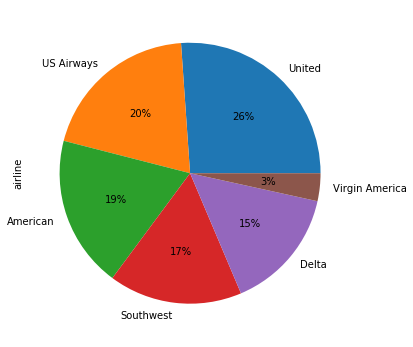

In [5]:
airline_tweets.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')

Let's now see the distribution of sentiments across all the tweets. Execute the following script:

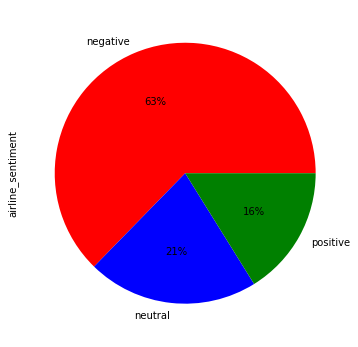

In [6]:
airline_tweets.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['red', 'blue','green'])

From the output, you can see that the majority of the tweets are negative (63%), followed by neutral tweets (21%), and then the positive tweets (16%).

Next, let's see the distribution of sentiment for each individual airline,

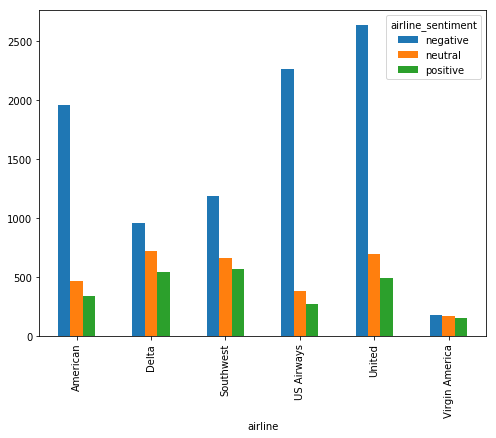

In [7]:
airline_sentiment = airline_tweets.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

It is evident from the output that for almost all the airlines, the majority of the tweets are negative, followed by neutral and positive tweets. Virgin America is probably the only airline where the ratio of the three sentiments is somewhat similar.

Finally, let's use the Seaborn library to view the average confidence level for the tweets belonging to three sentiment categories. Execute the following script:

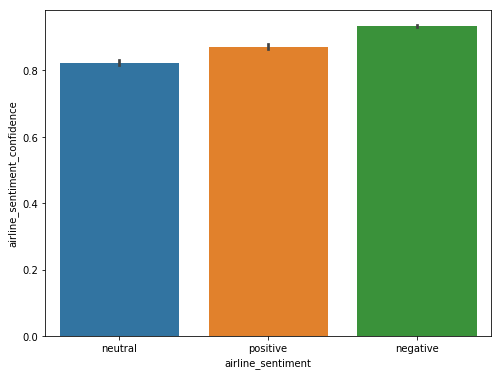

In [8]:
sns.barplot(x='airline_sentiment', y='airline_sentiment_confidence', data=airline_tweets)

From the output, you can see that the confidence level for negative tweets is higher compared to positive and neutral tweets.

## Data Cleaning
Tweets contain many slang words and punctuation marks. We need to clean our tweets before they can be used for training the machine learning model. However, before cleaning the tweets, let's divide our dataset into feature and label sets.

Our feature set will consist of tweets only. If we look at our dataset, the 11th column contains the tweet text. Note that the index of the column will be 10 since pandas columns follow zero-based indexing scheme where the first column is called 0th column. Our label set will consist of the sentiment of the tweet that we have to predict. The sentiment of the tweet is in the second column (index 1). To create a feature and a label set, we can use the iloc method off the pandas data frame.

In [9]:
features = airline_tweets.iloc[:, 10].values
labels = airline_tweets.iloc[:, 1].values

features

array(['@VirginAmerica What @dhepburn said.',
       "@VirginAmerica plus you've added commercials to the experience... tacky.",
       "@VirginAmerica I didn't today... Must mean I need to take another trip!",
       ...,
       '@AmericanAir Please bring American Airlines to #BlackBerry10',
       "@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",
       '@AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?'],
      dtype=object)

Once we divide the data into features and training set, we can preprocess data in order to clean it. To do so, we will use regular expressions. To study more about regular expressions, please take a look at this article on regular expressions.

In [10]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)
    

In the script above, we start by removing all the special characters from the tweets. The regular expression re.sub(r'\W', ' ', str(features[sentence])) does that.

Next, we remove all the single characters left as a result of removing the special character using the re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature) regular expression. For instance, if we remove special character ' from Jack's and replace it with space, we are left with Jack s. Here s has no meaning, so we remove it by replacing all single characters with a space.

However, if we replace all single characters with space, multiple spaces are created. Therefore, we replace all the multiple spaces with single spaces using re.sub(r'\s+', ' ', processed_feature, flags=re.I) regex. Furthermore, if your text string is in bytes format a character b is appended with the string. The above script removes that using the regex re.sub(r'^b\s+', '', processed_feature).

Finally, the text is converted into lowercase using the lower() function.

# Representing Text in Numeric Form
Statistical algorithms use mathematics to train machine learning models. However, mathematics only work with numbers. To make statistical algorithms work with text, we first have to convert text to numbers. To do so, three main approaches exist i.e. Bag of Words, TF-IDF and Word2Vec. In this section, we will discuss the bag of words and TF-IDF scheme.

# Bag of Words
Bag of words scheme is the simplest way of converting text to numbers.

For instance, you have three documents:

Doc1 = "I like to play football"
Doc2 = "It is a good game"
Doc3 = "I prefer football over rugby"
In the bag of words approach the first step is to create a vocabulary of all the unique words. For the above three documents, our vocabulary will be:

Vocab = [I, like, to, play, football, it, is, a, good, game, prefer, over, rugby]
The next step is to convert each document into a feature vector using the vocabulary. The length of each feature vector is equal to the length of the vocabulary. The frequency of the word in the document will replace the actual word in the vocabulary. If a word in the vocabulary is not found in the corresponding document, the document feature vector will have zero in that place. For instance, for Doc1, the feature vector will look like this:


[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]

# TF-IDF
In the bag of words approach, each word has the same weight. The idea behind the TF-IDF approach is that the words that occur less in all the documents and more in individual document contribute more towards classification.

TF-IDF is a combination of two terms. Term frequency and Inverse Document frequency. They can be calculated as:

TF  = (Frequency of a word in the document)/(Total words in the document)

IDF = Log((Total number of docs)/(Number of docs containing the word))
TF-IDF using the Scikit-Learn Library
Luckily for us, Python's Scikit-Learn library contains the TfidfVectorizer class that can be used to convert text features into TF-IDF feature vectors. The following script performs this:

In [11]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

In the code above, we define that the max_features should be 2500, which means that it only uses the 2500 most frequently occurring words to create a bag of words feature vector. Words that occur less frequently are not very useful for classification.

Similarly, max_df specifies that only use those words that occur in a maximum of 80% of the documents. Words that occur in all documents are too common and are not very useful for classification. Similarly, min-df is set to 7 which shows that include words that occur in at least 7 documents

# Dividing Data into Training and Test Sets
In the previous section, we converted the data into the numeric form. As the last step before we train our algorithms, we need to divide our data into training and testing sets. The training set will be used to train the algorithm while the test set will be used to evaluate the performance of the machine learning model.

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In the code above we use the train_test_split class from the sklearn.model_selection module to divide our data into training and testing set. The method takes the feature set as the first parameter, the label set as the second parameter, and a value for the test_size parameter. We specified a value of 0.2 for test_size which means that our data set will be split into two sets of 80% and 20% data. We will use the 80% dataset for training and 20% dataset for testing.

# Training the Model
Once data is split into training and test set, machine learning algorithms can be used to learn from the training data. You can use any machine learning algorithm. However, we will use the Random Forest algorithm, owing to its ability to act upon non-normalized data.

The sklearn.ensemble module contains the RandomForestClassifier class that can be used to train the machine learning model using the random forest algorithm. To do so, we need to call the fit method on the RandomForestClassifier class and pass it our training features and labels, as parameters. Look at the following script:

In [14]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

# Making Predictions and Evaluating the Model
Once the model has been trained, the last step is to make predictions on the model. To do so, we need to call the predict method on the object of the RandomForestClassifier class that we used for training. Look at the following script:

In [17]:
predictions = text_classifier.predict(x_test)
# predictions[:15]
y_test[:15]

array(['negative', 'negative', 'negative', 'negative', 'negative',
       'neutral', 'negative', 'negative', 'negative', 'negative',
       'neutral', 'negative', 'neutral', 'negative', 'negative'],
      dtype=object)

In [17]:
print(predictions[0], y_test[0])

negative negative


Finally, to evaluate the performance of the machine learning models, we can use classification metrics such as a confusion metrix, F1 measure, accuracy, etc.

To find the values for these metrics, we can use classification_report, confusion_matrix, and accuracy_score utilities from the sklearn.metrics library. Look a the following script:

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

[[1723  108   39]
 [ 326  248   40]
 [ 132   58  254]]
              precision    recall  f1-score   support

    negative       0.79      0.92      0.85      1870
     neutral       0.60      0.40      0.48       614
    positive       0.76      0.57      0.65       444

   micro avg       0.76      0.76      0.76      2928
   macro avg       0.72      0.63      0.66      2928
weighted avg       0.75      0.76      0.74      2928

0.7599043715846995


# Conclusion
The sentiment analysis is one of the most commonly performed NLP tasks as it helps determine overall public opinion about a certain topic.

In this article, we saw how different Python libraries contribute to performing sentiment analysis. We performed an analysis of public tweets regarding six US airlines and achieved an accuracy of around 75%. I would recommend you to try and use some other machine learning algorithm such as logistic regression, SVM, or KNN and see if you can get better results.